In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from mol_gen_docking.data.pydantic_dataset import read_jsonl, write_jsonl, Sample, Message, Conversation
from pathlib import Path
import jsonlines
from typing import Dict, Any, List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm.auto import tqdm

In [61]:
SOURCE = "MiniMax-M2"
PATH = Path("MolGenOutput/molgendata_train") / SOURCE
PROMPT_PATH = Path("data/molgendata/train_data/train_prompts_boxed.jsonl")

prompt_dataset = read_jsonl(PROMPT_PATH)

comp_dataset = []
n_files = len(list(PATH.glob("*_scored.jsonl")))
for path in tqdm(PATH.glob("*_scored.jsonl"), total=n_files):
    with jsonlines.open(path) as reader:
        for obj in reader:
            comp_dataset.append(obj)
print(f"Extracted {len(comp_dataset)} completions from {n_files} files.")

  0%|          | 0/1 [00:00<?, ?it/s]

Extracted 1600 completions from 1 files.


In [63]:
from mol_gen_docking.evaluation.diversity_aware_top_k import diversity_aware_top_k

def completion_to_conv(
        completions: Dict[str, Any],
        prompt: Sample,
        threshold:float = 0.3,
        prop_max: float = 0.5,
) -> Sample | None:
    conversation = prompt.conversations[0]
    new_conversation_messages = []
    # Sort completions by reward and keep only the top prop_max
    completions = sorted(completions, key=lambda x: x["reward"], reverse=True)
    completions = [c for c in completions if c["reward"] >= threshold]
    if len(completions) == 0:
        return None

    n_to_keep = int(len(completions) * prop_max)
    if len(completions) > 1:
        _, keep_indices = diversity_aware_top_k(
            mols = [
               comp["reward_meta"]["generation_verifier_metadata"]["all_smi"][0] for comp in completions
            ],
            scores = [c["reward"] for c in completions],
            k=min(n_to_keep, len(completions)),
            t=0.2,
            fingerprint_name = "ecfp6-2048",
            return_idxs=True
        )
    else:
        keep_indices = [0]
    completions = [completions[i] for i in keep_indices]
    for completion in completions:
        if completion["reward"] < threshold:
            continue
        assistant_message = Message(
            role="assistant",
            content=completion["output"],
        )
        prompt_message = conversation.messages.copy()
        prompt_message.append(assistant_message)
        new_conversation = Conversation(
            messages=prompt_message,
            source=SOURCE,
            rating = completion["reward"],
            meta= conversation.meta,
            identifier=conversation.identifier,
            training_masks_strategy=conversation.training_masks_strategy,
        )
        new_conversation_messages.append(new_conversation)
    new_sample = Sample(
        conversations=new_conversation_messages,
        identifier=conversation.identifier,
    )
    return new_sample


In [75]:
N_per_prompt = 16

new_dataset = []

for i in range(0, len(comp_dataset), N_per_prompt):
    batch = comp_dataset[i:i+N_per_prompt]
    p_id = batch[0]["metadata"]["prompt_id"]
    assert all(b["metadata"]["prompt_id"] == p_id for b in batch), "All samples in the batch should have the same prompt_id"

    # Find the corresponding prompt
    prompt = next((p for p in prompt_dataset if p.identifier == p_id), None)
    assert prompt is not None, f"Prompt with id {p_id} not found in the prompt dataset"

    new_sample = completion_to_conv(batch, prompt)
    if new_sample is not None:
        new_dataset.append(new_sample)
    else:
        print(f"Prompt with id {p_id} could not be integrated into the new dataset due to low rewards:")
        print("\n=== " + " | ".join([f"{c['reward']:.2f}" for c in batch]) + " ===\n")


Prompt with id 390832007 could not be integrated into the new dataset due to low rewards:

=== 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 ===

Prompt with id 390832007 could not be integrated into the new dataset due to low rewards:

=== 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 ===

Prompt with id 3911220 could not be integrated into the new dataset due to low rewards:

=== 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 ===

Prompt with id 390832007 could not be integrated into the new dataset due to low rewards:

=== 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 ===

Prompt with id 3911220 could not be integrated into the new dataset due to low rewards:

=== 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 |

In [66]:
import pandas as pd

all_rewards = [
    {
        "reward": conv.rating,
        "source": conv.source,
        "identifier": conv.identifier,
        "i": float(i)
    }
    for sample in new_dataset for i, conv in enumerate(sample.conversations)
]
all_rewards = pd.DataFrame(all_rewards)

In [73]:
all_rewards.identifier.nunique()

9

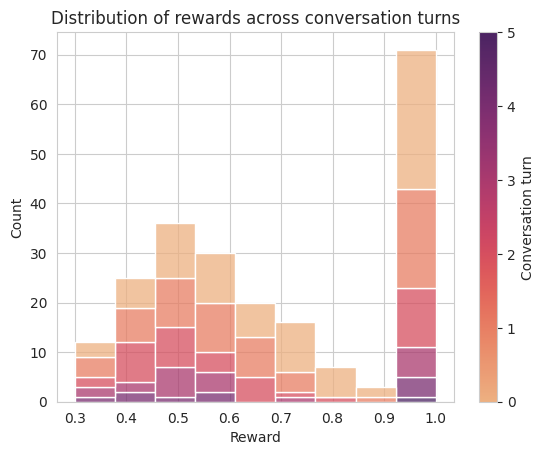

In [68]:
sns.histplot(
    data=all_rewards, x="reward", hue="i", palette = "flare", multiple="stack"
)
# Remove legend to replace by a color bar
plt.legend([], [], frameon=False)
# Put a colorbar
norm = plt.Normalize(all_rewards["i"].min(), all_rewards["i"].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Conversation turn", ax=plt.gca())

plt.xlabel("Reward")
plt.title("Distribution of rewards across conversation turns")
plt.show()

<Axes: xlabel='identifier', ylabel='Count'>

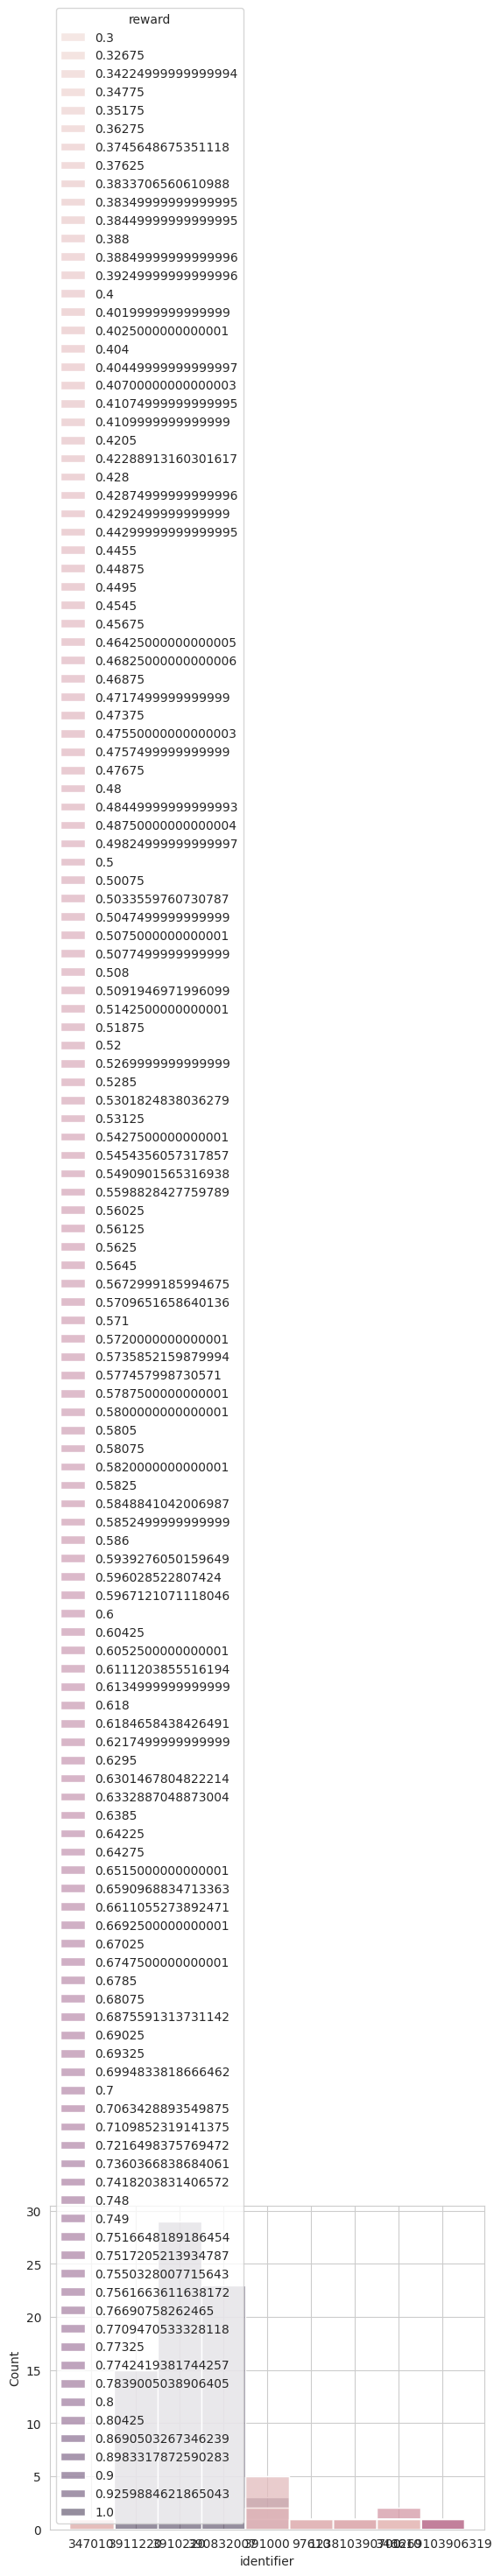

In [71]:
sns.histplot(
    data=all_rewards, x="identifier", hue="reward")

In [57]:
len(new_dataset)

83